#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


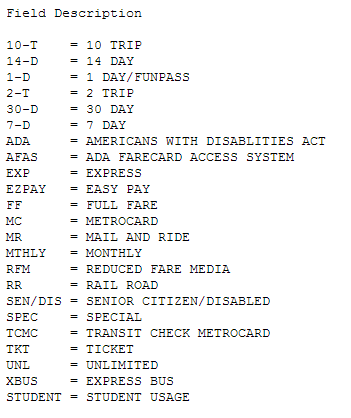

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [2]:
import pylab as pl
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [4]:
mta = np.load("MTA_Fare.npy")
mta = mta.astype(float)
mta.shape

(600, 23, 194)

In [5]:
# clean up the data
mta[mta==-1] = np.nan
# Sum up fare for all ride types
mta_allsum =np.nansum(mta, axis=0)
mta_allsum = pd.DataFrame(mta_allsum)
mta_allsum.shape

(23, 194)

In [6]:
date = pd.date_range(start='05/21/2010', end='02/21/2014', freq='W')
date = date[2:]
date.shape

(194,)

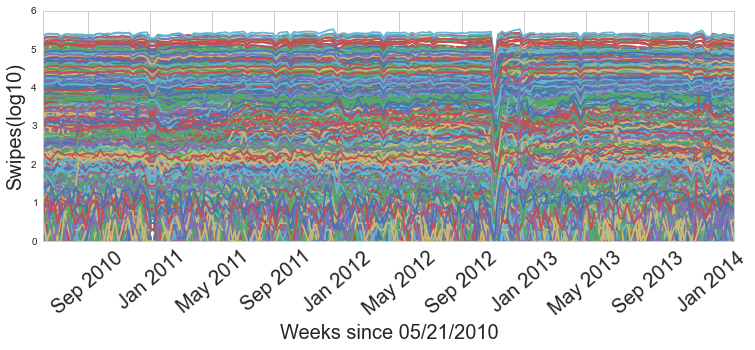

In [7]:
fig = figure(figsize=(12,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xlabel('Weeks since 05/21/2010', size=20)
ax.set_ylabel('Swipes(log10)', size=20)
ax.tick_params(axis='x',labelsize=10)
pl.xticks(rotation=40, fontsize=20)
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        ax.plot(date, np.log10(mta[i,j]))

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.


#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


#EXTRA CREDIT: Cluster. 
##Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
##Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

#Task1

In [8]:
# test the approach of threshold
thresholds = [mta_allsum.loc[0,:].mean() + 3*mta_allsum.loc[0,:].std(), 
              mta_allsum.loc[0,:].mean() - 3*mta_allsum.loc[0,:].std()]
print thresholds

[16889312.352366973, 9595433.585777357]


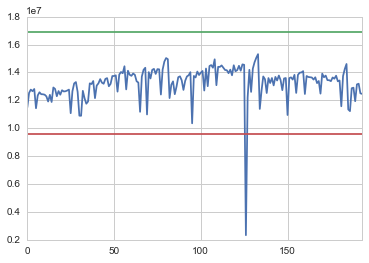

In [10]:
ax = mta_allsum.loc[0,:].plot()
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])

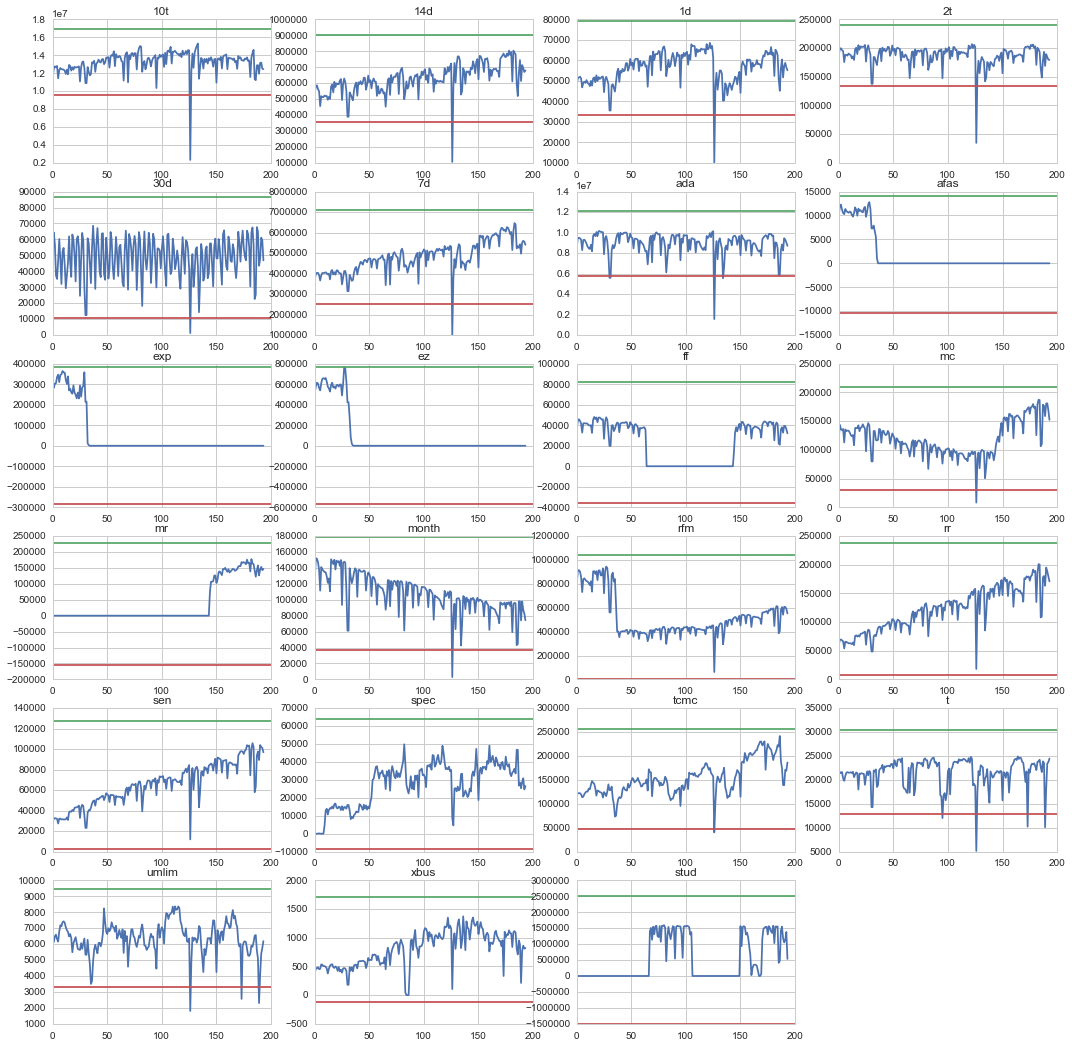

In [13]:
# Plot the week against total ride for all staion.
fig = plt.figure(figsize=(18,18))
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            ax.plot(mta_allsum.loc[i*4+j,:])
            thresholds = [mta_allsum.loc[i*4+j,:].mean() + 3*mta_allsum.loc[i*4+j,:].std(), 
                          mta_allsum.loc[i*4+j,:].mean() - 3*mta_allsum.loc[i*4+j,:].std()]
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])
            ax.set_title(ridetype[i*4+j])

In [14]:
# Event detection
events = pd.Series()
for i in range(23):
    thresholds = [mta_allsum.loc[i,:].mean() + 3*mta_allsum.loc[i,:].std(), 
                  mta_allsum.loc[i,:].mean() - 3*mta_allsum.loc[i,:].std()]
   
    event = (mta_allsum.loc[i,:]<thresholds[1])
    events = pd.concat([events, pd.Series(date[event.index[event==True]])], axis=0, ignore_index=True)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

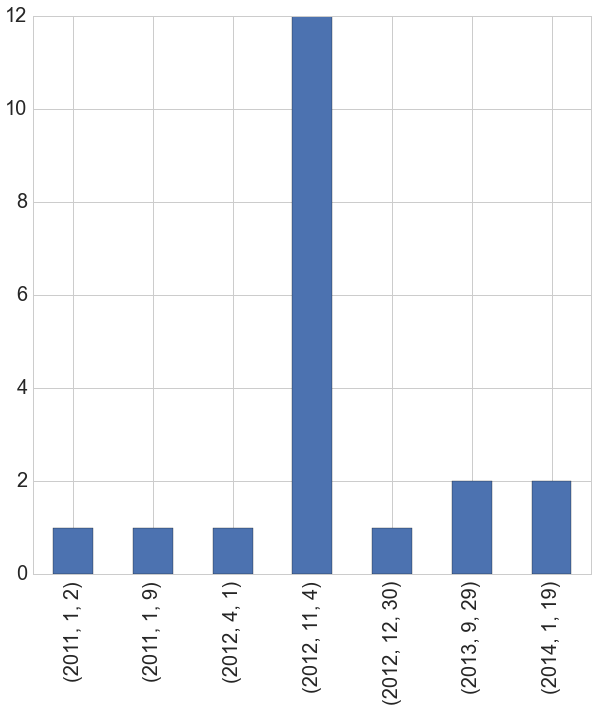

In [15]:
events.sort()
events.groupby([events.dt.year, events.dt.month, events.dt.day]).count().plot(kind="bar",fontsize=20, figsize=(10,10))
pl.xticks(rotation=90)

# Comment:

The drop in MTA fare in November 4, 2012 was caused by the Hurricane Sandy.

#Task 2

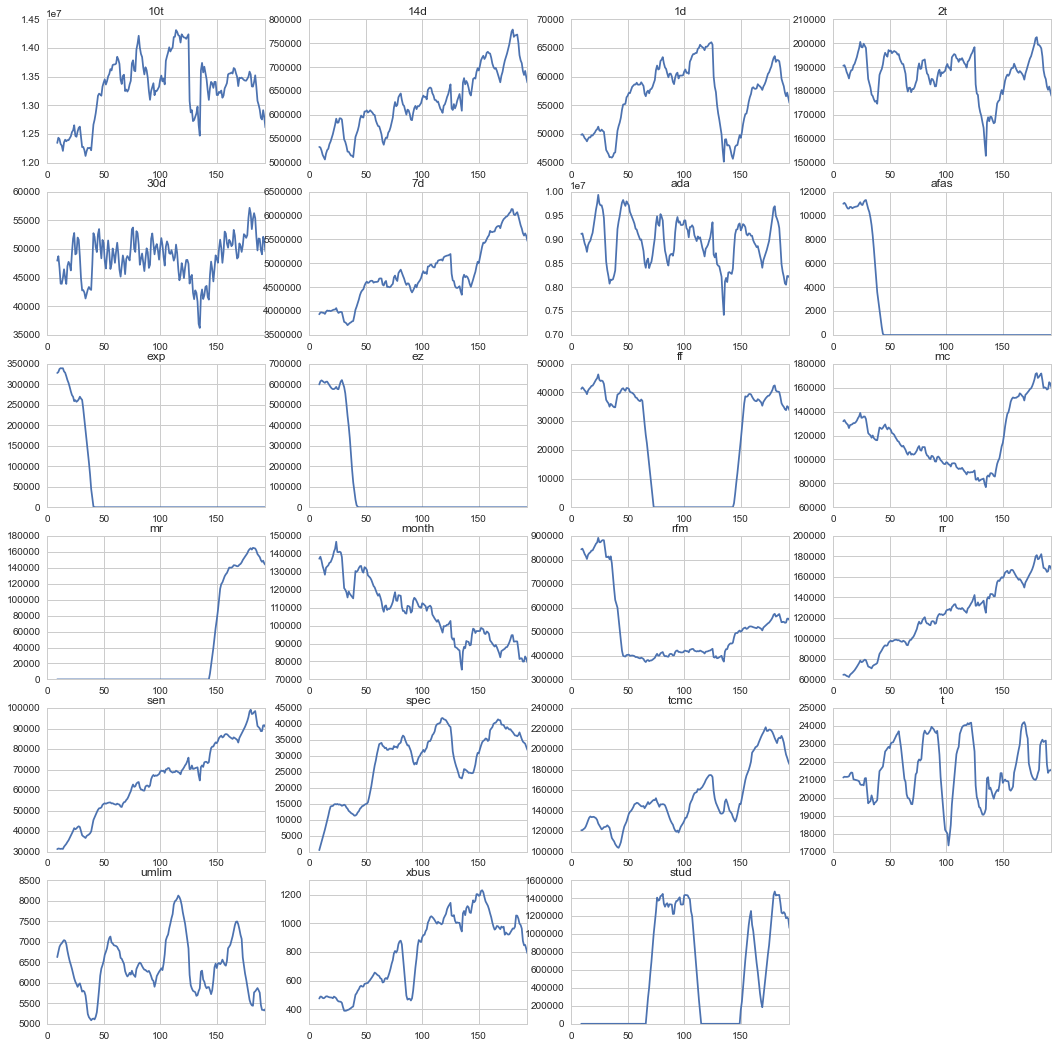

In [16]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
ratio = np.zeros(23)
std = np.zeros(23)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            roll_mean = pd.rolling_mean(mta_allsum.loc[i*4+j,:], 10)
            ax = roll_mean.plot()
            ratio[i*4+j] = roll_mean.loc[9]/roll_mean.loc[193]
            std[i*4+j] = np.nanstd(roll_mean)
            ax.set_title(ridetype[i*4+j])

In [19]:
from tabulate import tabulate
table = pd.DataFrame({'Type' : ridetype,
                     'Ratio of Beginning over Ending 10 weeks' : ratio,
                     'Std' : std})
print table

    Ratio of Beginning over Ending 10 weeks            Std   Type
0                                  0.978667  546777.616992    10t
1                                  0.798681   64593.901400    14d
2                                  0.899810    5767.412494     1d
3                                  1.070889    8828.003856     2t
4                                  0.967317    3624.088526    30d
5                                  0.719555  631955.017784     7d
6                                  1.111307  473487.373171    ada
7                               4774.478261    3794.926774   afas
8                              93571.342857  101444.891854    exp
9                             665798.555556  206370.776156     ez
10                                 1.221296   18800.946529     ff
11                                 0.824035   25371.323554     mc
12                                 0.000040   61154.073440     mr
13                                 1.727944   17282.833852  month
14        

#Comment:

14d, 7d, mc, rr, sem, spec can be regarded as increase
  
While ride type "month" 'rmf' decrease and "afas", "exp", "ez" decrease followed with a drop to zero.

#Task 3

In [24]:
mta_allsum = np.nansum(mta, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum_1 = np.nansum(mta, axis=1)

(23, 194)


In [25]:
mta_allsum1 = mta_allsum_1.T

In [26]:
df1 = pd.DataFrame(mta_allsum1)

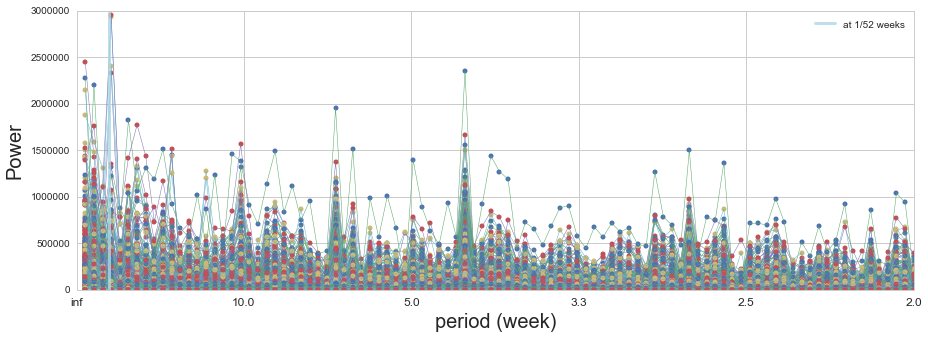

In [27]:
N = len(df1)

fig=plt.figure(figsize=(15,5))
for i in range(599):
    f = np.abs(np.fft.rfft(df1[i+1]))
    ax=fig.add_subplot(111)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-', lw=.5);
ax.set_xticklabels([ "{:.1f}".format(1/x) for x in ax.get_xticks()], fontsize=12)
plt.xlabel("period (week)", fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.axvline(1.0/52,lw=3, color='lightblue', label='at 1/52 weeks',alpha=0.8)
plt.legend()

In [38]:
station = []
power = []
for i in range(599):
    x = (np.abs(np.fft.rfft(df1[i],)[1:]))
    station.append(i)
    power.append(x[3])

In [39]:
dic = {'station':station,'power':power}
df2 = pd.DataFrame(dic)

In [42]:
df2.sort('power', ascending=0).head(4)

,power,station
0,2980160.635595,0
194,2950388.929214,194
150,2931895.876951,150
327,2402218.580959,327


#Comment: 

Station 0,150,194 and 327 are the most prominent 4 stations.

#Extra credit: 

The input features are not independent such as with time series data. In this case SVMs and Naive Bayes would not be a good choice since they assume that the input features are independent. The k-NN algorithm could still work however it relies on the notion of a similarity measure between input examples. Now the question becomes how do we measure the similarity between two time series? 

I refer the solution on https://github.com/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb

In [ ]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [ ]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return sqrt(LB_sum)

In [ ]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        #print ind
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [ ]:
train = np.genfromtxt('datasets/train.csv', delimiter='\t')
test = np.genfromtxt('datasets/test.csv', delimiter='\t')
print knn(train,test,4)

##NOTE ON THE TREND DETECTION:
###you should find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking for something that has a more or less constant trend

###to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

###you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.

###notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


###below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

std: 153167.095823 
flux ratio beginning to end 1.53960256599
std: 33307.6081244 
flux ratio beginning to end 0.378670623705


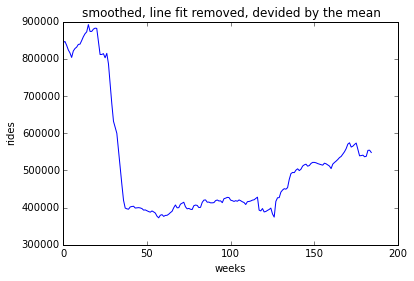

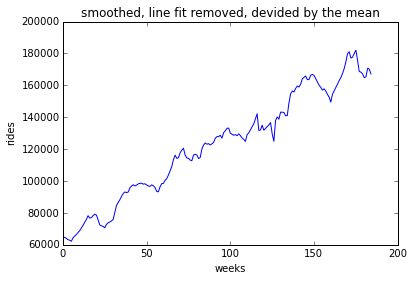

##to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
##an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

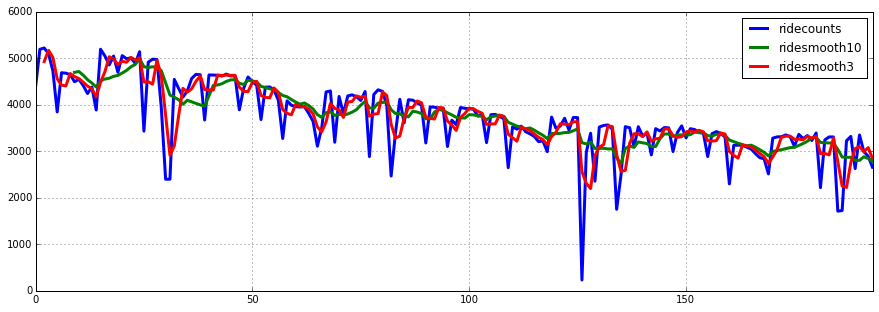

In [14]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

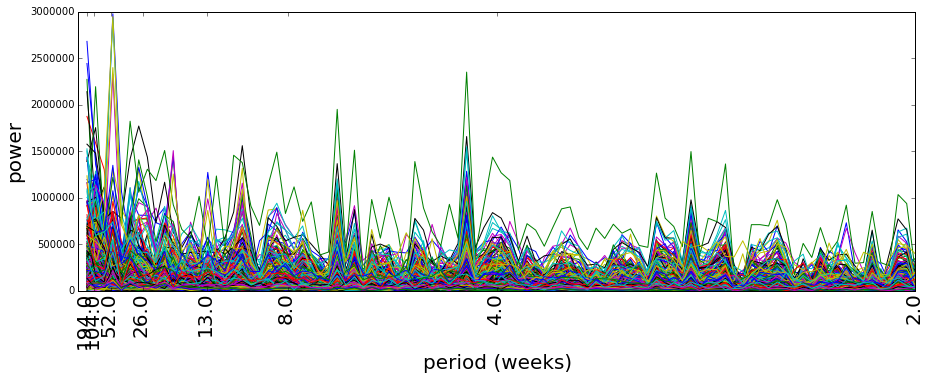

In [51]:
#this is a "power spectrum": the plot of the absolute value of the fourier transform. 
#I changed the xtick labels from frequecy (1/week) to period (in weeks)
#to facilitate the visual identification of the 1-year period peak
#(notice however that np.fft.rfftfreq(N, d)  returns frequency)

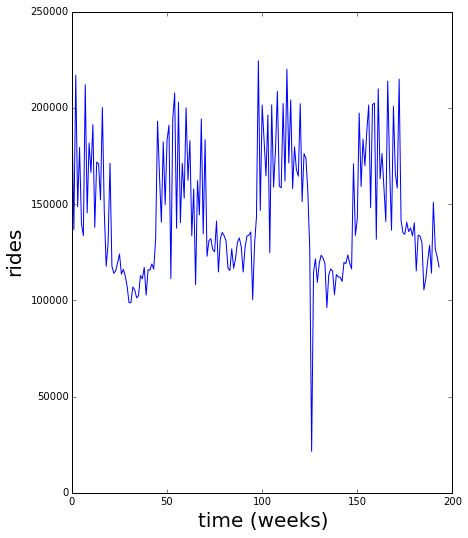

In [63]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space